In [1]:
from enum import Enum
import pandas as pd
import numpy as np

class Activation(str, Enum):
    SIGMOID = "Sigmoid"
    SOFTMAX = "Softmax"

class Layer:
    def __init__(self, neurons, activation):
        self.activation = activation
        self.w = None        
        self.b = np.random.uniform(low=0, high=1, size=(neurons, 1))
        self.z = None
        self.a = None
        self.delta = []
        self.gradient_w= []
        self.gradient_b= []
        #self.z = np.zeros((neurons, batch_size))
        #self.a = np.zeros((neurons, batch_size)) # rows * cols
    def neuronsCount(self):
        return self.b.size        
        
class FNN:
    def __init__(self):
        self.layers = []
        self.inputsNodes = 0
        self.next_index = 0
        self.lostHist = []
        self.x_train = None
        self.batch_size = 1   
        self.loss = []
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        #isplay(self.sigmoid(z) * (1-self.sigmoid(z)))
        return self.sigmoid(z) * (1-self.sigmoid(z))        
    
    def softmax(self, z):
        return np.exp(z) / np.exp(z).sum(axis=0)
    
    def crossEntropy(self, a, y):
        return -np.sum(y * np.log(a), axis = 0)
    
    def addLayer(self, neurons, activation):
        layer = Layer(neurons, activation)
        self.layers.append(layer)
        
    def addInputs(self, inputsCount):
        self.inputsNodes = inputsCount
        
    def set_weights(self, initValue = 1):
        for i, layer in enumerate(self.layers):
            if i == 0 :
                layer.w = np.random.uniform(low=0, high=initValue, size=(self.inputsNodes,layer.neuronsCount()))
            else:
                layer.w = np.random.uniform(low=0, high=initValue, size=(self.layers[i-1].neuronsCount(),layer.neuronsCount()))
            
    def evaluateOne(self, x_batch, y_batch):
        for i,l in enumerate(self.layers):
            # Logit
            if i == 0:
                l.z = np.dot(l.w.T, x_batch) + l.b
            else:
                l.z = np.dot(l.w.T, self.layers[i-1].a) + l.b
            # Activation
            if(l.activation == Activation.SIGMOID):
                l.a = self.sigmoid(l.z)
            else:
                l.a = self.softmax(l.z)      

    def backpropagation(self, x_batch, y_batch, rate):
        for j,l in enumerate(self.layers[::-1]):
            i = len(self.layers) - (1 + j)
            if i == len(self.layers) -1:
                l.delta = l.a - y_batch
                l.gradient_w = np.einsum('ij,jk->jik', self.layers[i-1].a, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            elif i == 0:
                l.delta = np.multiply(self.sigmoid_derivative(l.z), np.dot(self.layers[i+1].w, self.layers[i+1].delta))
                l.gradient_w= np.einsum('ij,jk->jik', x_batch, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            else:
                l.delta = np.multiply(self.sigmoid_derivative(l.z), np.dot(self.layers[i+1].w, self.layers[i+1].delta))
                l.gradient_w= np.einsum('ij,jk->jik', self.layers[i-1].a, l.delta.T)
                l.gradient_w = np.mean(l.gradient_w, axis=0)
                l.gradient_b = np.mean(l.delta, axis=1)
            
        for l in self.layers:
            l.gradient_b = l.gradient_b.reshape(len(l.gradient_b), 1)
            l.w -= rate*l.gradient_w
            l.b -= rate*l.gradient_b
            
    def train(self, x_train, y_train, epochs, rate, batch_size = 1):
        self.set_weights()        
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size   
        
        shuffleTime = int(np.ceil(len(self.x_train)/self.batch_size))        
       
        for epoch in range(epochs):
            idx = np.random.permutation(self.x_train.index)
            self.x_train = self.x_train.reindex(idx).reset_index(drop=True, inplace=False)
            self.y_train = self.y_train.reindex(idx).reset_index(drop=True, inplace=False)
            self.next_index = 0
            epochLoss = []            
            for it in range(shuffleTime):            
                current_index = self.next_index
                self.next_index = self.next_index + self.batch_size if self.next_index + self.batch_size < len(self.x_train) - 1 else 0

                x_batch = self.x_train.iloc[current_index:].to_numpy().T if self.next_index == 0 else self.x_train.iloc[current_index: self.next_index].to_numpy().T
                y_batch = np.vstack(self.y_train.iloc[current_index:].to_numpy()).T if self.next_index == 0 else np.vstack(self.y_train.iloc[current_index:self.next_index].to_numpy()).T        

                self.evaluateOne(x_batch, y_batch)
                loss = np.mean(self.crossEntropy(self.layers[-1].a, y_batch))
                epochLoss.append(loss)
                self.backpropagation(x_batch, y_batch, rate)
            if(epoch% 100 == 0 or epoch == epochs-1):
                print("Epoch {} / {} - Loss : {}".format(epoch+1, epochs, np.mean(epochLoss)))
            self.loss.append(np.mean(epochLoss))

In [2]:
np.random.seed(40)
np.set_printoptions(linewidth=np.inf)

def combine_to_list(row):
    return np.array([row['Iris-setosa'], row['Iris-versicolor'], row['Iris-virginica']])

# Load csv
df = pd.read_csv("iris_csv.csv")

# One hot econding class
classCols = pd.get_dummies(df['class'], prefix='', prefix_sep='')
df = pd.concat([df, classCols.apply(combine_to_list, axis = 1)], axis=1)
df.drop(['class'], axis=1, inplace=True)

# shuffle before split
df = df.sample(frac = 1).reset_index(drop=True, inplace=False)

# Split train/test
msk = np.random.rand(len(df)) < 0.8
train, test = df[msk], df[~msk]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Split training datas between X and Y
y_train = train[0]
x_train = train.iloc[:, :-1]

# Normalize
minimum = x_train.min(axis=0)
maximum = x_train.max(axis=0)
x_train = (x_train - minimum) / (maximum - minimum)
print("Minimum : {} ".format(minimum.tolist()))
print("Maximum : {}".format(maximum.tolist()))

Minimum : [4.3, 2.0, 1.0, 0.1] 
Maximum : [7.9, 4.4, 6.9, 2.5]


In [3]:
model = FNN()
model.addInputs(4)
model.addLayer(4, Activation.SIGMOID)
model.addLayer(3, Activation.SIGMOID)
model.addLayer(3, Activation.SOFTMAX)
model.train(x_train, y_train, epochs = 10000, rate = .01, batch_size = 5)

Epoch 1 / 10000 - Loss : 1.1584353977521604
Epoch 101 / 10000 - Loss : 1.093087194410527
Epoch 201 / 10000 - Loss : 1.0883704399623126
Epoch 301 / 10000 - Loss : 1.0800145703924051
Epoch 401 / 10000 - Loss : 1.05631887151527
Epoch 501 / 10000 - Loss : 0.9735338493293626
Epoch 601 / 10000 - Loss : 0.728618875016746
Epoch 701 / 10000 - Loss : 0.5407209381471056
Epoch 801 / 10000 - Loss : 0.4622626465000252
Epoch 901 / 10000 - Loss : 0.40495379538896836
Epoch 1001 / 10000 - Loss : 0.34941635764463297
Epoch 1101 / 10000 - Loss : 0.2999443390420996
Epoch 1201 / 10000 - Loss : 0.2581388690944315
Epoch 1301 / 10000 - Loss : 0.22286746752834943
Epoch 1401 / 10000 - Loss : 0.19395146718009415
Epoch 1501 / 10000 - Loss : 0.169930695588569
Epoch 1601 / 10000 - Loss : 0.15079600321421724
Epoch 1701 / 10000 - Loss : 0.13490104527555438
Epoch 1801 / 10000 - Loss : 0.12276444699650663
Epoch 1901 / 10000 - Loss : 0.11199133411941381
Epoch 2001 / 10000 - Loss : 0.10408856869093164
Epoch 2101 / 10000 - 

Good prediction : 25/25 | 100.0%



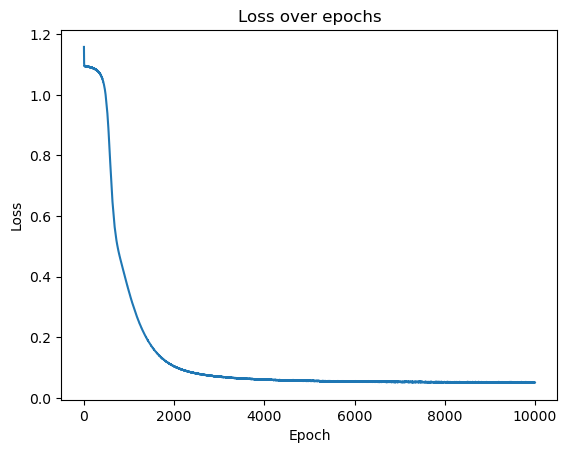

In [6]:
import matplotlib.pyplot as plt

# Split test datas between X and Y
y_test = test[0]
x_test = test.iloc[:, :-1]

# Normalize
x_test = (x_test - minimum) / (maximum - minimum)

# Transpose X & Y (observations in columns)
x_batch_test = x_test.to_numpy().T
y_batch_test = np.stack(y_test.to_numpy()).T

# Predict for all tests datas
model.evaluateOne( x_batch_test, y_batch_test)

# Plot loss over epochs
plt.plot(model.loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')

# Good prediciton rate
max_indices = np.argmax(model.layers[-1].a, axis=0)
matching_counts = np.sum(y_batch_test[max_indices, np.arange(model.layers[-1].a.shape[1])])
print("Good prediction : {}/{} | {}%\n".format(matching_counts, len(max_indices), (matching_counts * 100) / len(max_indices)))